In [27]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load data

In [2]:
with open("../Data/toy_dataset.pickle", "rb") as f:
    graph_data = pickle.load(f)

In [9]:
dir_data = '../Data/toy_dataset'

path_data = dir_data + ".pickle"
data_file = open(path_data, 'rb')
history_u_lists, history_ur_lists, history_v_lists, history_vr_lists, train_u, train_v, train_r, test_u, test_v, test_r, social_adj_lists, ratings_list = pickle.load(
    data_file)

In [18]:
dir_data = '../Data/Ciao/dataset/processed_data'

path_data = dir_data + ".pkl"
data_file = open(path_data, 'rb')
history_u_lists, history_ur_lists, history_v_lists, history_vr_lists, train_u, train_v, train_r, test_u, test_v, test_r, social_adj_lists, ratings_list = pickle.load(
    data_file)

In [2]:
with open('../Data/Ciao/dataset/processed_data.pkl', "rb") as f:
    ciao_graph_data = pickle.load(f)

In [4]:
train_u = ciao_graph_data["train_u"]
train_v = ciao_graph_data["train_v"]
train_r = ciao_graph_data["train_r"]

trainset = torch.utils.data.TensorDataset(torch.LongTensor(train_u), torch.LongTensor(train_v),
                                            torch.FloatTensor(train_r))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

In [8]:
for i, data in enumerate(train_loader, 0):
        batch_nodes_u, batch_nodes_v, labels_list = data
        for u in batch_nodes_u.tolist():
                if u not in ciao_graph_data["history_u_lists"]:
                        print(f"error with key : {u}")
                        exit(1)

In [8]:
rating_path = "../Data/Ciao/Dataset/rating.txt"

# Lecture ligne par ligne en splitant proprement
data = []
with open(rating_path, "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split("::::")
        if len(parts) >= 4:
            try:
                user = parts[0]
                product = parts[1]
                rating = float(parts[3])  # On prend le 4e champ (index 3)
                time = parts[5]
                category = parts[2]
                data.append((user, product, rating, time, category))
            except ValueError:
                continue  # Ignorer les lignes corrompues

ratings_df = pd.DataFrame(data, columns=["UserID", "ProductID", "Rating", "time", "Category"])
ratings_df = ratings_df[ratings_df["Rating"] <= 50]

In [13]:
ratings_df.to_csv("ratings_df.csv", sep=";", index=False)

# Categories_by_index

In [31]:
# Import
with open("../Src/prod2idx.pkl", "rb") as f:
    prod2idx = pickle.load(f)

ratings_df = pd.read_csv("../Src/ratings_df.csv", sep=";", low_memory=False)

idx2prod = {v: k for k, v in prod2idx.items()}

In [33]:
ratings_unique = ratings_df.drop_duplicates(subset="ProductID")

# On crée une Series indexée par ProductID, qui renvoie directement un string
category_map = ratings_unique.set_index("ProductID")["Category"]

categories_by_index = []
for i in tqdm(range(len(idx2prod))):
    prod_name = idx2prod[i]
    # On récupère la catégorie, ou 'Unknown' si l’item n’est pas dans le map
    cat = category_map.get(prod_name, "Unknown")
    categories_by_index.append(cat)

100%|██████████| 112802/112802 [00:00<00:00, 699403.05it/s]


In [36]:
with open("categories_by_index.pkl", "wb") as f:
    pickle.dump(categories_by_index, f)

# Plots

In [11]:
def plot_graph(graph_data, index=0, title="Graph"):
    """Affiche un graphe donné à partir de graph_data"""
    G = nx.Graph()

    # Sélectionne un des 12 dictionnaires (par défaut, le premier)
    graph_dict = graph_data[index]

    # Ajouter les arêtes au graphe
    for src, dst_list in graph_dict.items():
        for dst in dst_list:
            G.add_edge(src, dst)

    # Affichage
    plt.figure(figsize=(10, 6))
    nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray",
            node_size=500, font_size=10)
    plt.title(f"{title} (Graph {index})")
    plt.show()

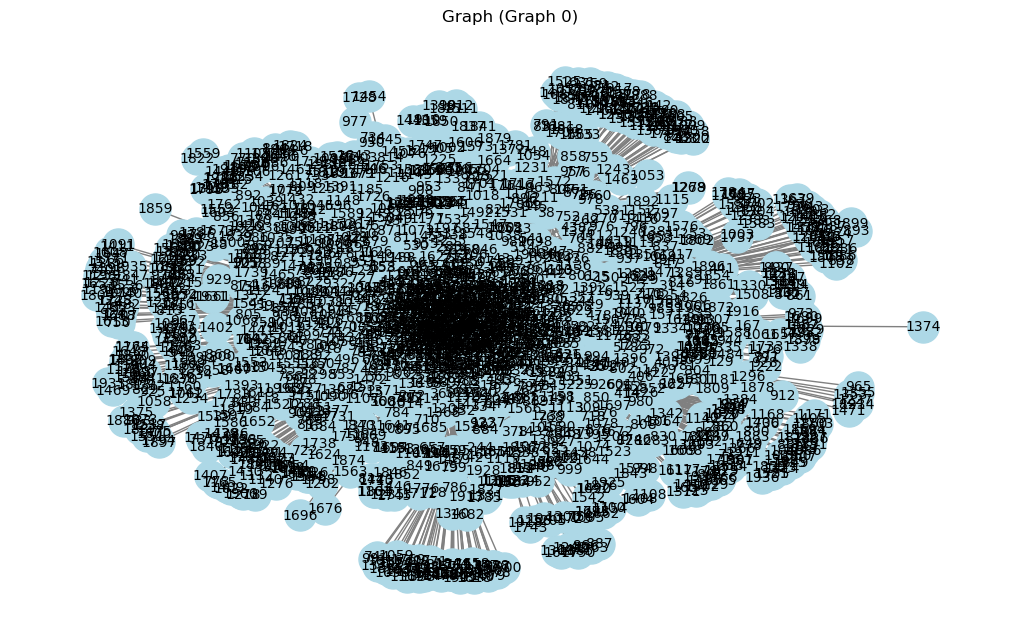

In [12]:
# Affichage du premier graphe
plot_graph(graph_data)

In [16]:
for i in range(len(graph_data)):
    print(len(graph_data[i]))

705
705
1941
1941
14091
14091
14091
3733
3733
3733
705
8


# Model

In [ ]:
# Configuration
NUM_USERS = 100
NUM_ITEMS = 50
EMBEDDING_DIM = 32
RATING_LEVELS = 5  # 1-5

# Génération de données synthétiques
def generate_synthetic_data():
    # Matrice de notes utilisateur-item (0 = non noté)
    ratings = torch.randint(0, 6, (NUM_USERS, NUM_ITEMS)).float()
    
    # Matrice de relations sociales (binaire)
    social_adj = torch.randint(0, 2, (NUM_USERS, NUM_USERS))
    social_adj = social_adj * (1 - torch.eye(NUM_USERS))  # Pas de self-connection
    
    return ratings, social_adj

# Modèle GraphRec simplifié
class SimpleGraphRec(nn.Module):
    def __init__(self):
        super().__init__()
        self.user_emb = nn.Embedding(NUM_USERS, EMBEDDING_DIM)
        self.item_emb = nn.Embedding(NUM_ITEMS, EMBEDDING_DIM)
        self.rating_emb = nn.Embedding(RATING_LEVELS + 1, EMBEDDING_DIM)  # 0-5
        
        # Attention pour les items
        self.item_attention = nn.Sequential(
            nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM),
            nn.ReLU(),
            nn.Linear(EMBEDDING_DIM, 1)
        )
        
        # MLP pour prédiction
        self.mlp = nn.Sequential(
            nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM),
            nn.ReLU(),
            nn.Linear(EMBEDDING_DIM, 1)
        )
    
    def forward(self, user_ids, item_ids):
        # Embeddings de base
        users = self.user_emb(user_ids)  # [batch, emb]
        items = self.item_emb(item_ids)  # [batch, emb]
        
        # Agrégation des items avec attention
        batch_ratings = ratings[user_ids]  # [batch, num_items]
        
        item_weights = []
        for i, user in enumerate(user_ids):
            rated_items = torch.where(batch_ratings[i] > 0)[0]
            if len(rated_items) == 0:
                item_agg = torch.zeros(EMBEDDING_DIM)
            else:
                # Embedding des items + notes
                item_embs = self.item_emb(rated_items)
                rating_embs = self.rating_emb(batch_ratings[i][rated_items].long())
                combined = torch.cat([item_embs, rating_embs], dim=1)
                
                # Calcul des poids d'attention
                attn_scores = self.item_attention(combined).squeeze()
                attn_weights = torch.softmax(attn_scores, dim=0)
                
                # Agrégation pondérée
                item_agg = torch.sum(item_embs * attn_weights.unsqueeze(-1), dim=0)
            
            item_weights.append(item_agg)
        
        item_agg = torch.stack(item_weights)  # [batch, emb]
        
        # Combinaison final + prédiction
        combined = torch.cat([users, item_agg], dim=1)
        pred = self.mlp(combined)
        return pred.squeeze()

In [ ]:
# Entraînement
ratings, social_adj = generate_synthetic_data()
model = SimpleGraphRec()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Exemple d'entraînement (batch size=1 pour simplicité)
for epoch in range(10):
    total_loss = 0
    for user in range(NUM_USERS):
        for item in range(NUM_ITEMS):
            if ratings[user, item] > 0:
                optimizer.zero_grad()
                pred = model(torch.tensor([user]), torch.tensor([item]))
                loss = criterion(pred, ratings[user, item].unsqueeze(0))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / (NUM_USERS * NUM_ITEMS)}")

In [19]:
# Configuration
EMBEDDING_DIM = 32
RATING_LEVELS = 5  # 1-5
BATCH_SIZE = 64

# ----------------------------------------------------
# Structure supposée des 12 defaultdict (à adapter selon vos données)
# ----------------------------------------------------
# [
#     train_user_dict, train_item_dict, train_rating_dict,
#     val_user_dict, val_item_dict, val_rating_dict,
#     test_user_dict, test_item_dict, test_rating_dict,
#     social_dict, user_features_dict, item_features_dict
# ]
# ----------------------------------------------------

class SocialDataset(Dataset):
    def __init__(self, data_tuple, mode="train"):
        # Extraire les defaultdict pertinents
        offset = 0 if mode == "train" else 3 if mode == "val" else 6
        self.user_dict = data_tuple[offset]
        self.item_dict = data_tuple[offset + 1]
        self.rating_dict = data_tuple[offset + 2]
        self.social_dict = data_tuple[9]
        
        # Créer des listes d'exemples (user, item, rating)
        self.examples = []
        for user in self.user_dict:
            for item, rating in zip(self.item_dict[user], self.rating_dict[user]):
                self.examples.append((user, item, rating))
                
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        user, item, rating = self.examples[idx]
        return torch.tensor(user), torch.tensor(item), torch.tensor(rating, dtype=torch.float)

# Modèle GraphRec adapté
class AdvancedGraphRec(nn.Module):
    def __init__(self, num_users, num_items):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        
        # Embeddings
        self.user_emb = nn.Embedding(num_users, EMBEDDING_DIM)
        self.item_emb = nn.Embedding(num_items, EMBEDDING_DIM)
        self.rating_emb = nn.Embedding(RATING_LEVELS + 1, EMBEDDING_DIM)  # 0-5
        
        # Modules d'attention
        self.item_attn = nn.Sequential(
            nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM),
            nn.ReLU(),
            nn.Linear(EMBEDDING_DIM, 1)
        )
        
        self.social_attn = nn.Sequential(
            nn.Linear(2 * EMBEDDING_DIM, EMBEDDING_DIM),
            nn.ReLU(),
            nn.Linear(EMBEDDING_DIM, 1)
        )
        
        # MLP de prédiction
        self.mlp = nn.Sequential(
            nn.Linear(3 * EMBEDDING_DIM, EMBEDDING_DIM),
            nn.ReLU(),
            nn.Linear(EMBEDDING_DIM, 1)
        )
    
    def forward(self, users, items):
        # Embeddings de base
        u_emb = self.user_emb(users)
        i_emb = self.item_emb(items)
        
        # ----------------------------------------------------
        # Agrégation des items (avec attention)
        # ----------------------------------------------------
        item_aggs = []
        for user in users:
            rated_items = torch.tensor([i for i in self.item_dict[user.item()]])
            ratings = torch.tensor([r for r in self.rating_dict[user.item()]]).long()
            
            if len(rated_items) == 0:
                item_agg = torch.zeros(EMBEDDING_DIM)
            else:
                item_embs = self.item_emb(rated_items)
                rating_embs = self.rating_emb(ratings)
                combined = torch.cat([item_embs, rating_embs], dim=1)
                
                attn_weights = torch.softmax(self.item_attn(combined).squeeze(), dim=0)
                item_agg = torch.sum(item_embs * attn_weights.unsqueeze(-1), dim=0)
            
            item_aggs.append(item_agg)
        
        item_aggs = torch.stack(item_aggs)
        
        # ----------------------------------------------------
        # Agrégation sociale (avec attention)
        # ----------------------------------------------------
        social_aggs = []
        for user in users:
            friends = torch.tensor([f for f in self.social_dict[user.item()]])
            
            if len(friends) == 0:
                social_agg = torch.zeros(EMBEDDING_DIM)
            else:
                friend_embs = self.user_emb(friends)
                combined = torch.cat([friend_embs, u_emb.unsqueeze(0).repeat(len(friends), 1)], dim=1)
                
                attn_weights = torch.softmax(self.social_attn(combined).squeeze(), dim=0)
                social_agg = torch.sum(friend_embs * attn_weights.unsqueeze(-1), dim=0)
            
            social_aggs.append(social_agg)
        
        social_aggs = torch.stack(social_aggs)
        
        # Combinaison finale
        combined = torch.cat([u_emb, item_aggs, social_aggs], dim=1)
        return self.mlp(combined).squeeze()

# ----------------------------------------------------
# Utilisation
# ----------------------------------------------------
def train_model(data_tuple):
    # Initialisation
    num_users = len(data_tuple[0])
    num_items = len(data_tuple[1])
    
    train_dataset = SocialDataset(data_tuple, mode="train")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = AdvancedGraphRec(num_users, num_items)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Entraînement
    for epoch in range(10):
        total_loss = 0
        for batch_users, batch_items, batch_ratings in train_loader:
            optimizer.zero_grad()
            preds = model(batch_users, batch_items)
            loss = criterion(preds, batch_ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")



In [20]:
# Exemple d'utilisation
if __name__ == "__main__":
    
    # Entraîner le modèle
    train_model(graph_data)

AttributeError: 'AdvancedGraphRec' object has no attribute 'item_dict'